# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [159]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-07-15/data_eval_new/"
file_name = "int_norm_20160715_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [160]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [50]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [161]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

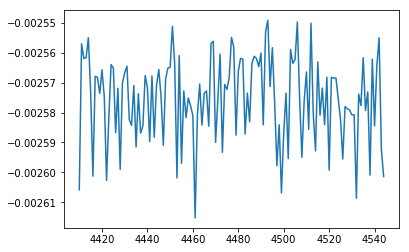

In [162]:
# Check Baselines
column = "117"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

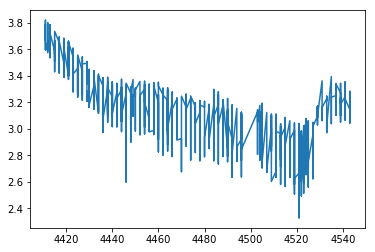

In [163]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

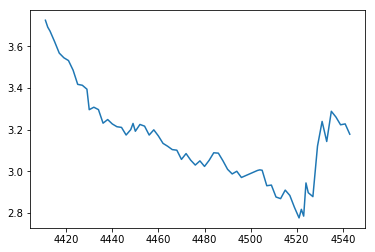

In [164]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

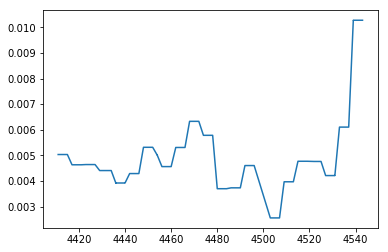

In [165]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [166]:
background_mean = df_mean(background)

# Outlier rejection

In [225]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te125_Xe129_corr"

In [226]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [227]:
column = "124/120"
sample = "NIST 200ppb"

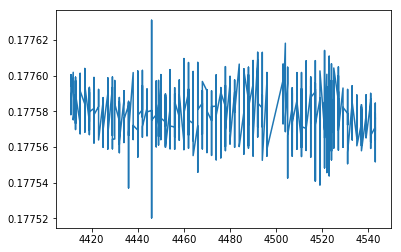

In [228]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [229]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [230]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2016-07-15 15:10:00,NIST 200ppb,2,1,4411,0.029819,NaN,0.010357,0.445960,0.235313,0.742935,0.263482,0.142099,0.177594
2016-07-15 15:10:00,NIST 200ppb,2,2,4411,0.029809,0.020181,0.010359,0.445958,0.235305,0.742935,0.263494,0.142099,0.177601
2016-07-15 15:10:00,NIST 200ppb,2,3,4411,0.029809,0.020178,0.010360,0.445961,0.235311,0.742935,0.263486,0.142105,0.177600
2016-07-15 15:10:00,NIST 200ppb,2,4,4411,0.029808,0.020179,0.010361,0.445939,0.235308,0.742935,0.263481,0.142104,0.177596
2016-07-15 15:10:00,NIST 200ppb,2,5,4411,0.029814,0.020180,0.010358,0.445953,0.235315,NaN,0.263480,0.142093,0.177578
2016-07-15 15:10:00,NIST 200ppb,2,6,4411,0.029810,0.020180,0.010359,0.445945,0.235307,0.742935,0.263478,0.142101,0.177597
2016-07-15 15:10:00,NIST 200ppb,2,7,4411,0.029811,0.020180,0.010361,0.445948,0.235307,0.742935,0.263481,0.142096,0.177596
2016-07-15 15:10:00,NIST 200ppb,2,8,4411,0.029814,0.020181,0.010360,0.445951,0.235316,0.742935,0.263479,0.142097,0.177584
2016-07-15 15:10:00,NIST 200ppb,2,9,4411,0.029810,0.020180,0.010363,0.445957,0.235313,NaN,0.263484,0.142102,0.177590


In [231]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4411        2016-07-15 15:10:00    0.187177
4434        2016-07-15 20:17:00    0.187364
4436        2016-07-15 20:41:00    0.187327
            2016-07-15 20:41:00    0.187329
4445        2016-07-15 22:40:00    0.187345
4446        2016-07-15 22:54:00    0.187349
4452        2016-07-16 00:30:00    0.187390
4456        2016-07-16 01:30:00    0.187432
            2016-07-16 01:30:00    0.187427
4462        2016-07-16 02:49:00    0.187445
4490        2016-07-16 08:59:00    0.187488
            2016-07-16 08:59:00    0.187479
4492        2016-07-16 09:23:00    0.187514
4495        2016-07-16 10:04:00    0.187513
            2016-07-16 10:04:00    0.187513
            2016-07-16 10:04:00    0.187500
4511        2016-07-16 15:16:00    0.187515
4516        2016-07-16 16:21:00    0.187521
4519        2016-07-16 17:03:00    0.187495
4521        2016-07-16 17:26:00    0.187488
4528        2016-07-16 19:10:00    0.187888
            2016-07-16 19:10:00    0.186389


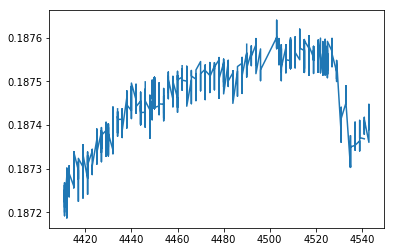

In [232]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [233]:
df[df["Sample"] == sample][column].std()

9.354980495933647e-05

In [234]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

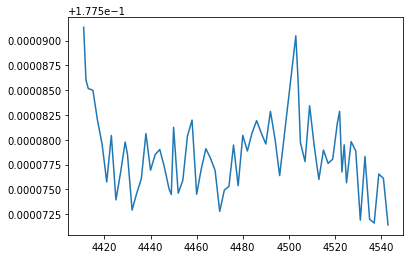

In [235]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [236]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2016-07-15 15:10:00,4411,NIST 200ppb,0.029812,0.020179,0.010361,0.445958,0.235314,0.742935,0.263482,0.142098,0.177591
2016-07-15 15:23:00,4412,NIST 200ppb,0.029811,0.020178,0.010361,0.445966,0.235316,0.742935,0.263483,0.142097,0.177586
2016-07-15 15:37:00,4413,NIST 200ppb,0.029813,0.020179,0.010361,0.445971,0.235318,0.742935,0.263482,0.142097,0.177585
2016-07-15 15:51:00,4414,NIST 350ppb,0.029817,0.020183,0.010362,0.445991,0.235326,0.742935,0.263488,0.142095,0.177580
2016-07-15 16:04:00,4415,NIST 200ppb,0.029816,0.020182,0.010362,0.445976,0.235318,0.742935,0.263482,0.142097,0.177585
2016-07-15 16:29:00,4417,NIST 200ppb,0.029814,0.020180,0.010360,0.445975,0.235320,0.742935,0.263482,0.142097,0.177582
2016-07-15 16:43:00,4418,NIST 200ppb + 0.440ppb Mo,0.029814,0.020180,0.010361,0.445980,0.235323,0.742935,0.263482,0.142094,0.177581
2016-07-15 16:56:00,4419,NIST 200ppb,0.029818,0.020184,0.010361,0.445981,0.235323,0.742935,0.263481,0.142093,0.177580
2016-07-15 17:10:00,4420,NIST 200ppb + 0.250ppb Pd,0.029814,0.020181,0.010361,0.445982,0.235320,0.742935,0.263481,0.142095,0.177583


In [237]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [238]:
drop_sum = [pd.Timestamp('2016-07-16 17:46:00')]

In [239]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [240]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [241]:
data_mean_int_sum

112/120                       114/120  \
                               mean           SD2 count      mean   
Sample                                                              
Allende bomb 1_1           0.029821           NaN     1  0.020185   
J.W. bomb 1_1              0.029818           NaN     1  0.020182   
J.W. bomb 1_2              0.029819           NaN     1  0.020182   
Murchison bomb 1_1         0.029819           NaN     1  0.020185   
Murchison bomb 1_2         0.029817           NaN     1  0.020183   
NIST 200ppb                0.029820  5.464165e-06    69  0.020184   
NIST 200ppb + 0.001ppb In  0.029821           NaN     1  0.020183   
NIST 200ppb + 0.005ppb U   0.029819  3.413205e-06     2  0.020183   
NIST 200ppb + 0.010ppb Cd  0.029820           NaN     1  0.020185   
NIST 200ppb + 0.015ppb U   0.029820           NaN     1  0.020182   
NIST 200ppb + 0.03ppb Cd   0.029820  7.475402e-06     2  0.020185   
NIST 200ppb + 0.040ppb Cd  0.029822           NaN     1  0.020188   
NIST 200ppb + 0.056ppb Zr  0.035801  2.072967e-02     3  0.024993   
NIST 200ppb + 0.082ppb Rh  0.029820  1.718009e-06     2  0.020185   
NIST 200ppb + 0.109ppb Ru  0.029821  2.537333e-06     2  0.020184   
NIST 200ppb + 0.250ppb Pd  0.029819  8.649527e-06     3  0.020183   
NIST 200ppb + 0.440ppb Mo  0.029819  8.335199e-06     3  0.020182   
NIST 200ppb + ME           0.029821  9.340335e-07     2  0.020186   
NIST 350ppb                0.029820  3.153900e-06     9  0.020185   

                                                115/120                      \
                                    SD2 count      mean           SD2 count   
Sample                                                                        
Allende bomb 1_1                    NaN     1  0.010360           NaN     1   
J.W. bomb 1_1                       NaN     1  0.010359           NaN     1   
J.W. bomb 1_2                       NaN     1  0.010360           NaN     1   
Murchison bomb 1_1                  NaN     1  0.010360           NaN     1   
Murchison bomb 1_2                  NaN     1  0.010360           NaN     1   
NIST 200ppb                3.344609e-06    69  0.010362  1.566382e-06    69   
NIST 200ppb + 0.001ppb In           NaN     1  0.010371           NaN     1   
NIST 200ppb + 0.005ppb U   2.012946e-06     2  0.010363  1.642028e-06     2   
NIST 200ppb + 0.010ppb Cd           NaN     1  0.010363           NaN     1   
NIST 200ppb + 0.015ppb U            NaN     1  0.010362           NaN     1   
NIST 200ppb + 0.03ppb Cd   6.126664e-06     2  0.010362  9.955749e-07     2   
NIST 200ppb + 0.040ppb Cd           NaN     1  0.010362           NaN     1   
NIST 200ppb + 0.056ppb Zr  1.666206e-02     3  0.009047  4.553480e-03     3   
NIST 200ppb + 0.082ppb Rh  1.861697e-06     2  0.010362  4.672853e-07     2   
NIST 200ppb + 0.109ppb Ru  1.564092e-06     2  0.010363  6.962066e-07     2   
NIST 200ppb + 0.250ppb Pd  6.405218e-06     3  0.010363  2.654527e-06     3   
NIST 200ppb + 0.440ppb Mo  4.086338e-06     3  0.010363  2.441903e-06     3   
NIST 200ppb + ME           9.109729e-07     2  0.010362  1.406633e-06     2   
NIST 350ppb                2.024903e-06     9  0.010363  1.764657e-06     9   

                            116/120  ...  118/120   119/120                  \
                               mean  ...    count      mean       SD2 count   
Sample                               ...                                      
Allende bomb 1_1           0.445991  ...        1  0.263473       NaN     1   
J.W. bomb 1_1              0.445990  ...        1  0.263472       NaN     1   
J.W. bomb 1_2              0.445996  ...        1  0.263472       NaN     1   
Murchison bomb 1_1         0.445996  ...        1  0.263472       NaN     1   
Murchison bomb 1_2         0.445991  ...        1  0.263474       NaN     1   
NIST 200ppb                0.445990  ...       69  0.263475  0.000007    69   
NIST 200ppb + 0.001ppb In  0.445993  ...        1  0.263472

In [242]:
date_list = [pd.Timestamp('2016-07-16 00:54:00'),
            pd.Timestamp('2016-07-16 17:46:00')]


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [243]:

date_list = [pd.Timestamp('2016-07-15 22:13:00'),
             pd.Timestamp('2016-07-16 07:26:00')]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [244]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [245]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [246]:
epsilon_int_200

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2016-07-15 15:23:00,4412,-0.505183,-0.609602,0.319496,0.042338,0.003435,2.220446e-12,0.025750,-0.033698,-0.124948,NIST 200ppb
2016-07-15 15:37:00,4413,-0.095156,-0.279264,-0.577202,-0.011657,0.037987,-1.110223e-12,0.001079,-0.021764,-0.019710,NIST 200ppb
2016-07-15 15:51:00,4414,0.882823,1.313569,-0.135721,0.405238,0.330702,0.000000e+00,0.228262,-0.122729,-0.299197,NIST 350ppb
2016-07-15 16:04:00,4415,0.693523,1.002225,1.508845,0.067830,-0.038400,2.220446e-12,-0.000228,0.007718,0.080518,NIST 200ppb
2016-07-15 16:29:00,4417,-0.766580,-1.248081,-1.116552,-0.077484,-0.019002,0.000000e+00,0.000021,0.157367,-0.017280,NIST 200ppb
2016-07-15 16:43:00,4418,-0.663123,-0.909997,0.738246,0.051761,0.052839,-1.110223e-12,0.029776,-0.061179,0.013503,NIST 200ppb + 0.440ppb Mo
2016-07-15 16:56:00,4419,0.715539,1.177248,-0.030262,0.022878,0.001577,-1.110223e-12,-0.017416,-0.131784,0.038969,NIST 200ppb
2016-07-15 17:10:00,4420,-0.830902,-1.120295,0.385488,-0.026159,-0.168812,0.000000e+00,-0.000271,0.198839,0.307922,NIST 200ppb + 0.250ppb Pd
2016-07-15 17:24:00,4421,0.013684,-0.097329,-0.188945,0.106590,0.180461,2.220446e-12,0.042442,-0.107073,-0.238967,NIST 200ppb


In [247]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [248]:
epsilon_sum_all

112/120              114/120              115/120  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
Allende bomb 1_1           -0.131    NaN     1   0.573    NaN     1  -2.755   
J.W. bomb 1_1              -0.883    NaN     1  -0.832    NaN     1  -3.386   
J.W. bomb 1_2              -0.189    NaN     1  -0.600    NaN     1  -2.352   
Murchison bomb 1_1         -0.446    NaN     1   0.653    NaN     1  -2.272   
Murchison bomb 1_2         -1.261    NaN     1  -0.497    NaN     1  -2.411   
NIST 200ppb                -0.007  0.898    66  -0.011  1.211    66   0.004   
NIST 200ppb + 0.001ppb In   0.450    NaN     1  -0.149    NaN     1   8.605   
NIST 200ppb + 0.005ppb U   -0.142  1.431     2  -0.376  1.106     2   0.542   
NIST 200ppb + 0.010ppb Cd  -0.540    NaN     1   0.063    NaN     1  -0.494   
NIST 200ppb + 0.015ppb U   -0.385    NaN     1  -0.561    NaN     1  -0.972   
NIST 200ppb + 0.03ppb Cd    0.363  1.469     2   1.034  2.023     2  -0.203   
NIST 200ppb + 0.040ppb Cd   0.780    NaN     1   2.055    NaN     1  -0.642   
NIST 200ppb + 0.056ppb Zr   0.330    NaN     1   0.382    NaN     1  -0.099   
NIST 200ppb + 0.082ppb Rh   0.056  0.006     2   0.436  0.279     2   0.288   
NIST 200ppb + 0.109ppb Ru   0.312  0.861     2   0.219  1.652     2   0.037   
NIST 200ppb + 0.250ppb Pd  -0.434  0.699     3  -0.424  1.688     3   0.722   
NIST 200ppb + 0.440ppb Mo  -0.517  0.338     3  -0.987  0.510     3   0.551   
NIST 200ppb + ME            0.328  0.128     2   0.924  0.101     2  -0.219   
NIST 350ppb                -0.031  1.811     9   0.355  1.582     9   0.289   

                                       116/120  ...  118/120 119/120         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
Allende bomb 1_1             NaN     1  -0.199  ...        1  -0.064    NaN   
J.W. bomb 1_1                NaN     1  -0.085  ...        1  -0.110    NaN   
J.W. bomb 1_2                NaN     1   0.160  ...        1  -0.111    NaN   
Murchison bomb 1_1           NaN     1   0.014  ...        1  -0.053    NaN   
Murchison bomb 1_2           NaN     1  -0.033  ...        1  -0.073    NaN   
NIST 200ppb                1.262    66   0.000  ...       66   0.001  0.189   
NIST 200ppb + 0.001ppb In    NaN     1   0.120  ...        1  -0.030    NaN   
NIST 200ppb + 0.005ppb U   0.927     2   0.102  ...        2   0.236  0.212   
NIST 200ppb + 0.010ppb Cd    NaN     1  -0.078  ...        1  -0.155    NaN   
NIST 200ppb + 0.015ppb U     NaN     1  -0.059  ...        1   0.421    NaN   
NIST 200ppb + 0.03ppb Cd   0.138     2  -0.015  ...        2   0.038  0.057   
NIST 200ppb + 0.040ppb Cd    NaN     1   0.006  ...        1   0.012    NaN   
NIST 200ppb + 0.056ppb Zr    NaN     1   0.040  ...        1  -0.002    NaN   
NIST 200ppb + 0.082ppb Rh  0.070     2   0.100  ...        2   0.042  0.098   
NIST 200ppb + 0.109ppb Ru  0.598     2   0.113  ...        2   0.049  0.199   
NIST 200ppb + 0.250ppb Pd  1.476     3  -0.029  ...        3   0.005  0.145   
NIST 200ppb + 0.440ppb Mo  1.289     3  -0.061  ...        3  -0.010  0.091   
NIST 200ppb + ME           0.293     2   0.040  ...        2   0.061  0.105   
NIST 350ppb                1.293     9   0.016  ...        9   0.144  0.171   

                                122/120              124/120               
                          count    mean    SD2 count    mean    SD2 count  
Sample                                                                     
Allende bomb 1_1              1   0.048    NaN     1   0.174    NaN     1  
J.W. bomb 1_1                 1  -0.105    NaN     1  -0.256    NaN     1  
J.W. bomb 1_2                 1  -0.278    NaN     1  -0.704    NaN     1  
Murchison bomb 1_1            1  -0.041    NaN     1  -0.349    NaN     1  
Murchison bomb 1

In [249]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [191]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [192]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [250]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [251]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [252]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [253]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')